<a href="https://colab.research.google.com/github/LatifulJoy/covid19-cnn-TL-mobilenet/blob/main/chest_x_ray11_10_22(without_BatchNormalization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
import os 
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

# Uploading Data

In [2]:
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"latifuljoy","key":"c9493e600d8dfc76ec7a58ea29031a33"}'}

In [3]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [4]:
!kaggle datasets download -d latifuljoy/covid-chest-xray-image-dataset

 96% 465M/484M [00:04<00:00, 132MB/s]
100% 484M/484M [00:04<00:00, 117MB/s]


In [5]:
!unzip \*.zip

Archive:  covid-chest-xray-image-dataset.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.png 

In [6]:
for dirpath,dirnames,filenames in os.walk("/content/COVID_IEEE"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


there are 3 directories and 0 images in '/content/COVID_IEEE'.
there are 0 directories and 536 images in '/content/COVID_IEEE/covid'.
there are 0 directories and 536 images in '/content/COVID_IEEE/virus'.
there are 0 directories and 536 images in '/content/COVID_IEEE/normal'.


# Augmentation

In [7]:
import pathlib
import tensorflow as tf
data_dir = pathlib.Path("/content/COVID_IEEE")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['covid', 'normal', 'virus'], dtype='<U6')

In [8]:
img_height =224
img_width =224

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.20,
    subset = 'training',
    seed =123,
    image_size = (img_height, img_width),
    batch_size = 32
)

Found 1493 files belonging to 3 classes.
Using 1195 files for training.


In [10]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.20,
    subset = 'validation',
    seed =123,
    image_size = (img_height, img_width),
    batch_size = 32
)

Found 1493 files belonging to 3 classes.
Using 298 files for validation.


In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [130]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, label_batch= next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixel values are now in (0,1)
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [131]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_ds= validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Developed CNN

In [234]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [236]:
model = Sequential()

#Block Number 1
model.add(Conv2D(input_shape = (224,224,3), filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

#Block Number 2
model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))
model.add(MaxPool2D((2,2)))

#Block Number 3
model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))

#Block Number 4
model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(MaxPool2D((2,2)))
model.add(MaxPool2D((2,2)))

Dropout(0.50)

# Fully Connected layer
model.add(Flatten())

model.add(Dense(units=1024, activation="relu"))
model.add(Dense(units=256, activation="relu"))
model.add(Dense(units=128, activation="relu"))
Dropout(0.50)

model.add(Dense(units=3, activation="softmax"))

In [237]:
model.compile(optimizer = opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [238]:
history1 = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs= 20
)

Epoch 1/20
38/38 [==============================] - 5s 124ms/step - loss: 0.8135 - accuracy: 0.6393 - val_loss: 0.5479 - val_accuracy: 0.7785
Epoch 2/20
38/38 [==============================] - 5s 121ms/step - loss: 0.3903 - accuracy: 0.8653 - val_loss: 0.3798 - val_accuracy: 0.8624
Epoch 3/20
38/38 [==============================] - 5s 122ms/step - loss: 0.2550 - accuracy: 0.9121 - val_loss: 0.2837 - val_accuracy: 0.8893
Epoch 4/20
38/38 [==============================] - 5s 124ms/step - loss: 0.1780 - accuracy: 0.9431 - val_loss: 0.2971 - val_accuracy: 0.8993
Epoch 5/20
38/38 [==============================] - 5s 124ms/step - loss: 0.1398 - accuracy: 0.9515 - val_loss: 0.3090 - val_accuracy: 0.8926
Epoch 6/20
38/38 [==============================] - 5s 124ms/step - loss: 0.1429 - accuracy: 0.9490 - val_loss: 0.2130 - val_accuracy: 0.9195
Epoch 7/20
38/38 [==============================] - 5s 123ms/step - loss: 0.1391 - accuracy: 0.9490 - val_loss: 0.1747 - val_accuracy: 0.9262
Epoch 

Text(0.5, 1.0, 'Accuracy Curves')

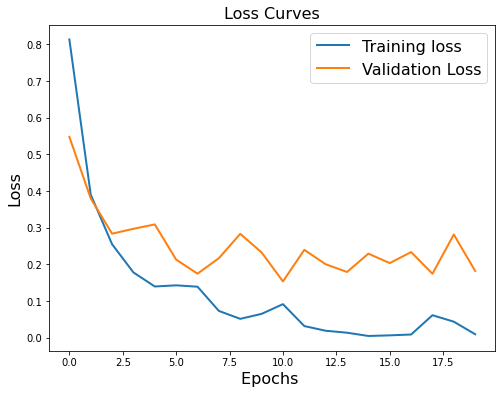

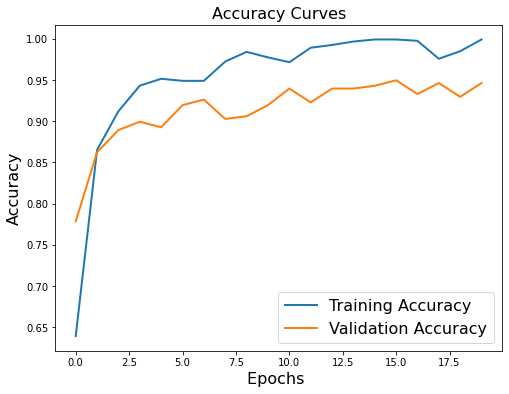

In [239]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['loss'],linewidth=2.0)
plt.plot(history1.history['val_loss'],linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['accuracy'],linewidth=2.0)
plt.plot(history1.history['val_accuracy'],linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)